In [1]:
import os
import seaborn as sns
# import cv2
from sklearn.metrics import confusion_matrix
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow.keras.models import Model
import itertools
from datetime import datetime

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [49]:
model_path = "CBAM-keras/saved_models/LW_ResNet20_tomato_adam_100_epochs.hdf5"
model = load_model(model_path)
model.summary()


Model: "LW_ResNet20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 16) 2368        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 16) 64          conv1[0][0]                      
________________________________________________________________________________________

In [4]:
def gen_image_label(directory):
    ''' A generator that yields (label, id, jpg_filename) tuple.'''
    for root, dirs, files in os.walk(directory):
        for f in files:
            _, ext = os.path.splitext(f)
            if ext != '.jpg':
                continue
            basename = os.path.basename(f)
            splits = basename.split('.')
            if len(splits) == 3:
                label, id_, ext = splits
            else:
                label = None
                id_, ext = splits
            fullname = os.path.join(root, f)
            yield label, int(id_), fullname
            

In [5]:
# testing of model
test_data_dir = 'D:/Anil/Dataset/tomato/test_imgs'
batch_size = 32
img_width, img_height = 256, 256

# Wrap testing data into pandas' DataFrame.
lst = list(gen_image_label(test_data_dir))
test_df = pd.DataFrame(lst, columns=['label', 'id', 'filename'])
test_df = test_df.sort_values(by=['label', 'id'])
test_df['label_code'] = test_df.label.map({'bacterial_spot':0,'early_blight':1,'fusarium_wilt':2,'healthy':3, 'late_blight':4, 'leaf_mold':5,
                                           'mosaic_virus':6, 'septoria_leaf_spot':7, 'spider_mites':8, 'target_spot':9, 
                                           'yellow_leaf_curl_virus':10})

test_df.head(100)

,label,id,filename,label_code
124,bacterial_spot,23,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
148,bacterial_spot,37,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
152,bacterial_spot,39,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
157,bacterial_spot,41,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
160,bacterial_spot,46,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
...,...,...,...,...
205,bacterial_spot,882,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
206,bacterial_spot,883,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
207,bacterial_spot,908,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0
208,bacterial_spot,934,D:/Anil/Dataset/tomato/test_imgs\bacterial_spo...,0


In [6]:
Y_true = test_df.label_code
print(Y_true)


124      0
148      0
152      0
157      0
160      0
        ..
1847    10
1848    10
1849    10
1850    10
1852    10
Name: label_code, Length: 1905, dtype: int64


In [19]:
# No need to run again once the file save in computer
import numpy as np
img_width = 256
img_height = 256
images = []
for img in test_df.filename:
    img = image.load_img(img, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    images.append(img)
# print(images)
# np.save("D:/Anil/Dataset/ageng_conf/test_imgs_299x299", images)
# stack up images list to pass for prediction
images = np.vstack(images)


In [50]:
test_start = datetime.now()
Y_pred = model.predict(images, batch_size=8)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
# classes = model.predict_classes(images, batch_size=8)
print(Y_pred_classes)
test_finish = datetime.now()
test_time = test_finish - test_start
print(test_time)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[ 0  0  0 ... 10 10 10]
0:00:01.514766


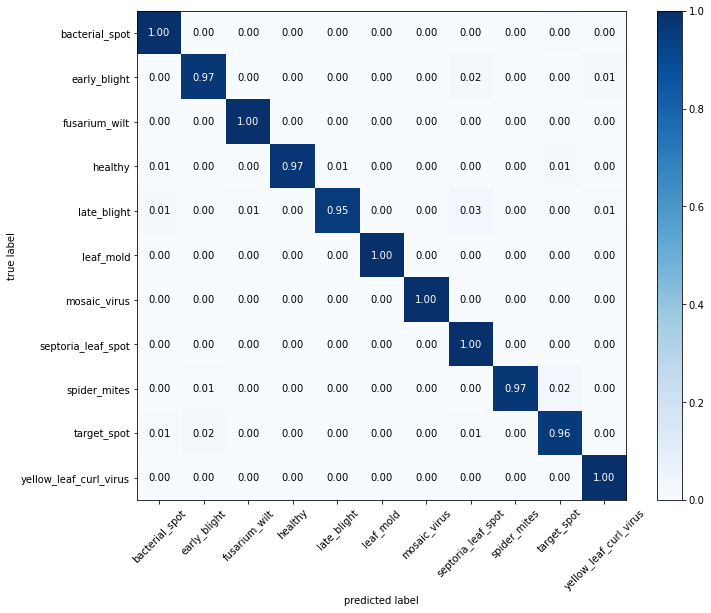

In [44]:
cls_name = ['bacterial_spot','early_blight','fusarium_wilt','healthy', 'late_blight', 'leaf_mold',
                                           'mosaic_virus', 'septoria_leaf_spot', 'spider_mites', 'target_spot', 
                                           'yellow_leaf_curl_virus']

ytrue = Y_true.values.flatten()
cm = confusion_matrix(ytrue, Y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                figsize = (11,9),
                               show_absolute=False,
                               show_normed=True,
                               colorbar=True,
                               class_names = cls_name)
plt.show()
# print(cm)


In [45]:
print(classification_report(Y_true, Y_pred_classes))
print('test accuracy: ', accuracy_score(Y_true, Y_pred_classes))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       214
           1       0.96      0.97      0.97       100
           2       0.99      1.00      0.99        80
           3       1.00      0.97      0.99       160
           4       0.99      0.95      0.97       192
           5       1.00      1.00      1.00        96
           6       1.00      1.00      1.00        38
           7       0.96      1.00      0.98       178
           8       1.00      0.97      0.98       169
           9       0.95      0.96      0.96       141
          10       1.00      1.00      1.00       537

    accuracy                           0.99      1905
   macro avg       0.98      0.98      0.98      1905
weighted avg       0.99      0.99      0.99      1905

test accuracy:  0.9858267716535433


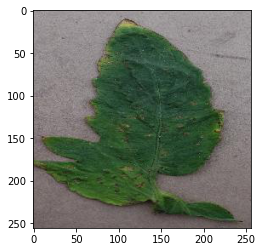

(1, 256, 256, 3)


In [23]:
# For intermediate layer output visualization
img_path = 'D:/Anil/Dataset/tomato/test_imgs/bacterial_spot.37.jpg'
img = image.load_img(img_path, target_size=(256, 256))
img_tensor = image.img_to_array(img)
img_tensor /= 255.
img_tensor = np.expand_dims(img_tensor, axis=0)

plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [24]:
# predicting images

image = np.vstack([img_tensor])
classes = model.predict(image, batch_size=10)
print(classes)
print("Predicted class is:",np.argmax(classes,axis=1))

[[9.9284571e-01 2.8402132e-05 2.4825853e-16 1.2205898e-19 7.0178050e-09
  2.8961648e-07 5.0476933e-20 3.0613396e-06 2.6382100e-13 4.4518802e-09
  7.1225991e-03]]
Predicted class is: [0]


In [46]:
# For layer visualization
for i, layer in enumerate(model.layers):
    print(i,layer.name)

0 input_3
1 zero_padding2d_2
2 conv1
3 bn_conv1
4 activation_33
5 max_pooling2d_2
6 res2a_branch2a
7 bn2a_branch2a
8 activation_34
9 res2a_branch2b
10 bn2a_branch2b
11 activation_35
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_10
17 activation_36
18 res3a_branch2a
19 bn3a_branch2a
20 activation_37
21 res3a_branch2b
22 bn3a_branch2b
23 activation_38
24 res3a_branch2c
25 res3a_branch1
26 bn3a_branch2c
27 bn3a_branch1
28 add_11
29 activation_39
30 res3b_branch2a
31 bn3b_branch2a
32 activation_40
33 res3b_branch2b
34 bn3b_branch2b
35 activation_41
36 res3b_branch2c
37 bn3b_branch2c
38 add_12
39 activation_42
40 res4a_branch2a
41 bn4a_branch2a
42 activation_43
43 res4a_branch2b
44 bn4a_branch2b
45 activation_44
46 res4a_branch2c
47 bn4a_branch2c
48 conv2d_4
49 conv2d_3
50 tf.reshape_7
51 tf.reshape_10
52 tf.reshape_6
53 tf.compat.v1.transpose_2
54 tf.compat.v1.transpose_3
55 tf.linalg.matmul_4
56 conv2d_5
57 tf.linalg.matmul_6
58 activation_45
59 tf.reshape_8
6

In [47]:
# Layers output visualization for SACNN
desired_layers = [39,83,95]
layer_outputs = [model.layers[i].output for i in desired_layers] 

#alternatively, you can use cnnModel.get_layer('layername').output for that    

activation_model = Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor) 


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\USER\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


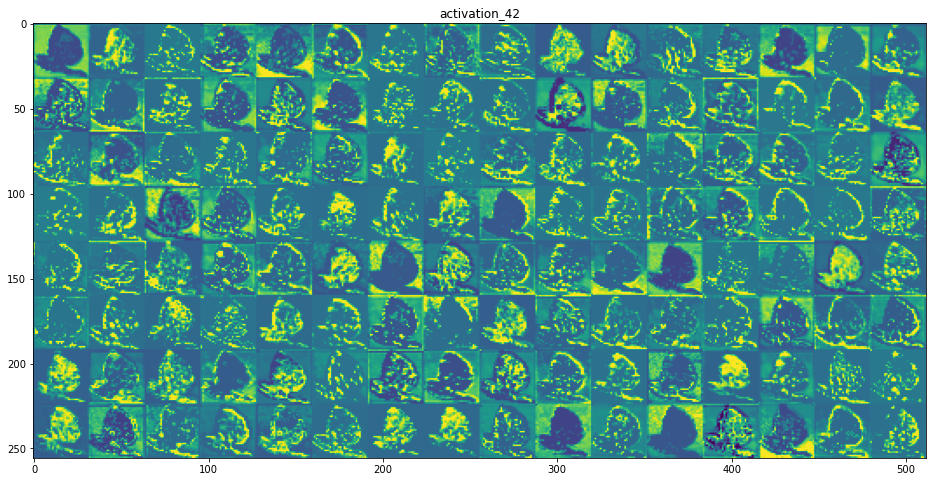

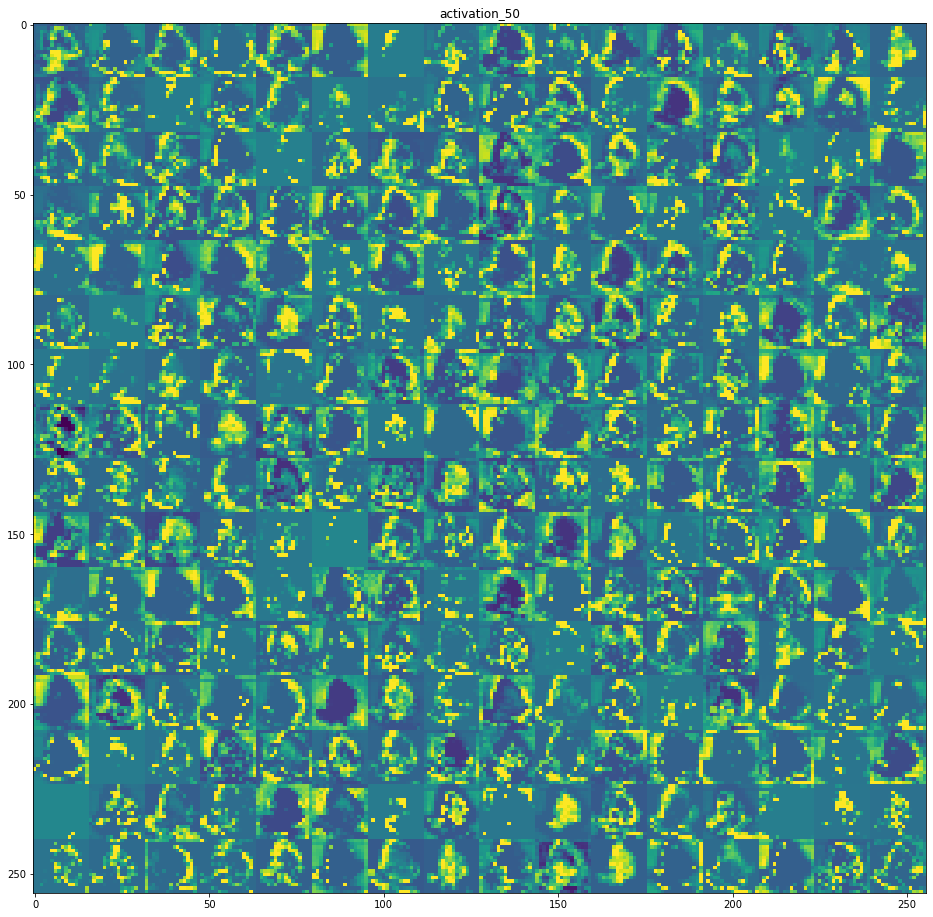

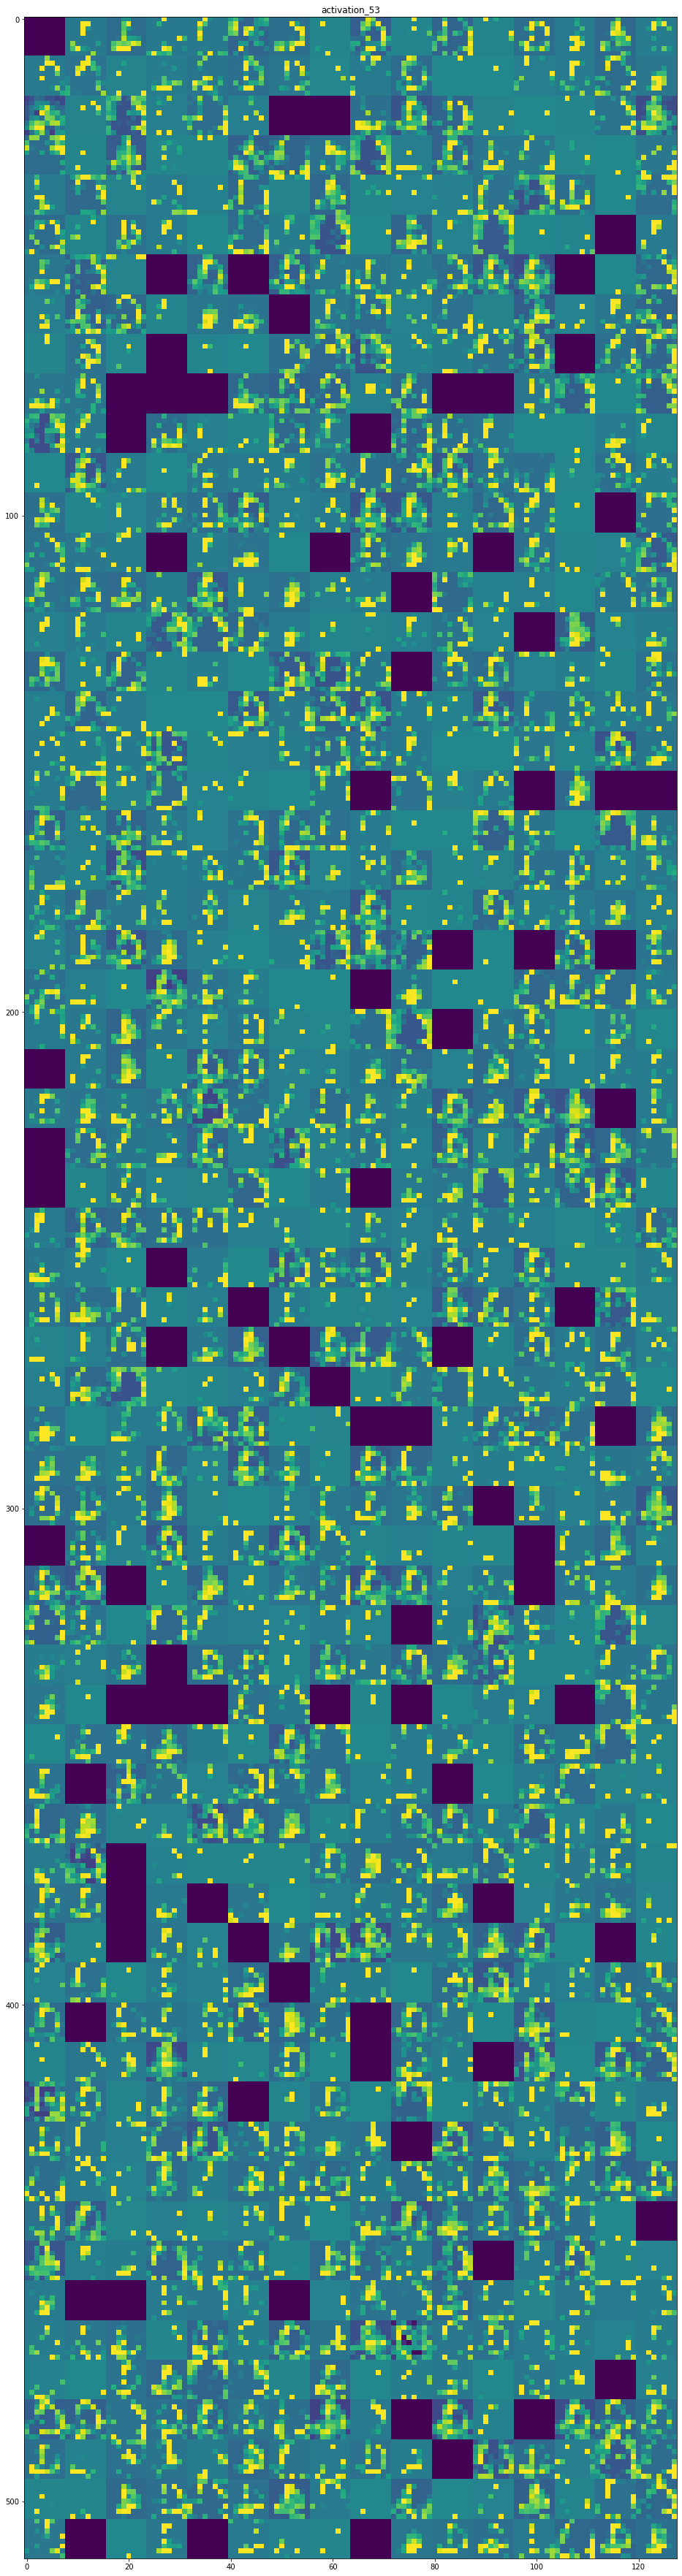

In [48]:
# Visualizing every channel in every intermediate activation
layer_names = []

# for layer in model.layers[:12]:
#     layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
for i in desired_layers:
    layer_names.append(model.layers[i].name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
 